# IMPORTS

In [ ]:
from __future__ import print_function, division

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Conv2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.datasets import mnist, fashion_mnist, cifar10
import tensorflow_datasets as tfds

from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

# INSTANCIATION ACGAN

In [ ]:
label_dict = {0: 'cat',
              1: 'dog',
              2: 'horse',
              3: 'car',
              4: 'truck',
              5: 'plane',
              6: 'frog',
              7: 'bird',
              8: 'boat',
              9: 'deer'}

In [ ]:
class AcGan_Cifar():
  def __init__(self, nb_rows, nb_columns, nb_channels, nb_classes, noise_dim=110):
    self.input_shape = (nb_rows, nb_columns, nb_channels)
    self.nb_classes = nb_classes
    self.noise_dim = noise_dim
    self.discriminator = Sequential()
    self.generator = Sequential()
    self.model = None
    self.optimizer = Adam(0.0001, 0.5, 0.999)
    #self.optimizer = Adam(0.001, 0.5, 0.999)
    self.losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']


  def instanciate_discriminator(self) :
    self.discriminator.add(Conv2D(16, kernel_size=3, strides=2, 
                                  input_shape=self.input_shape, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))

    self.discriminator.add(Conv2D(32, kernel_size=3, strides=1, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(64, kernel_size=3, strides=2, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))    
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(128, kernel_size=3, strides=1, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(256, kernel_size=3, strides=2, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(512, kernel_size=3, strides=1, 
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Flatten())
    self.discriminator.summary()

    # Extract feature representation
    img_real = Input(shape=self.input_shape)
    features = self.discriminator(img_real)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid", 
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)
    label = Dense(self.nb_classes+1, activation="softmax",
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)

    self.discriminator = Model(img_real, [validity, label])
    self.discriminator.compile(loss=self.losses,
      optimizer=self.optimizer,
      metrics=['accuracy'])

    self.discriminator.summary()


  def instanciate_generator(self):
    start_dim = self.input_shape[0] / 8
    if(start_dim % 1 != 0.0):
      raise ValueError('Image shape not divisible by 8')
    start_dim = int(start_dim)
    
    self.generator.add(Dense(24 * start_dim * start_dim, activation="relu", input_dim=self.noise_dim))
    self.generator.add(Reshape((start_dim, start_dim, 24)))
    #self.generator.add(BatchNormalization(momentum=0.8))
    #self.generator.add(UpSampling2D())

    self.generator.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))
    #self.generator.add(UpSampling2D())

    self.generator.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))

    self.generator.add(Conv2DTranspose(self.input_shape[2], kernel_size=5, strides=2, padding='same'))
    self.generator.add(Activation("tanh"))

    self.generator.summary()

    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.nb_classes, self.noise_dim)(label))

    model_input = multiply([noise, label_embedding])
    img_gen = self.generator(model_input)

    self.generator = Model([noise, label], img_gen)
    self.generator.summary()


  def instanciate_combined_model(self):
    # The generator takes noise and the target label as input and generates the corresponding digit of that label
    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    img_gen = self.generator([noise, label])

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated image as input and determines validity and the label of that image
    valid, target_label = self.discriminator(img_gen)

    # The combined model  (stacked generator and discriminator) trains the generator to fool the discriminator
    self.model = Model([noise, label], [valid, target_label])
    self.model.compile(loss=self.losses,
        optimizer=self.optimizer)
    

    def save(model, model_name):
      model_path = "../saved_model/%s.json" % model_name
      weights_path = "../saved_model/%s_weights.hdf5" % model_name
      options = {"file_arch": model_path,
                  "file_weight": weights_path}
      json_string = model.to_json()
      open(options['file_arch'], 'w').write(json_string)
      model.save_weights(options['file_weight'])

      #save(self.generator, "generator")
      #save(self.discriminator, "discriminator")



  def train(self, X_train, y_train, epochs, batch_size=100, sample_interval=50):
    # Configure inputs
    X_train = ( X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=4)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Loss output
    g_loss_epochs = np.zeros((epochs, 1))
    d_loss_epochs = np.zeros((epochs, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, self.nb_classes, (batch_size, 1))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
        img_labels = y_train[idx]
        fake_labels = self.nb_classes * np.ones(img_labels.shape)


        # Train the discriminator

        # mélanger les Set de imgs et gen_imgs, garder les index, et assigner les bons labels, train en 1 fois
        #d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
        #d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        all_imgs = np.concatenate((imgs, gen_imgs))
        all_sources = np.concatenate((valid, fake))
        all_labels = np.concatenate((img_labels, fake_labels))
        indices = np.indices((2*batch_size,))[0]
        np.random.shuffle(indices)
        d_loss = self.discriminator.train_on_batch(all_imgs[indices], [all_sources[indices], all_labels[indices]])

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = self.model.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        #show the final losses
        g_loss_epochs[epoch] = g_loss[0]
        d_loss_epochs[epoch] = d_loss[0]

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            # Plot the progress
            print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
            #do not save model
            #self.save_model()
            self.model.save('acgan.h5')
            #!gupload --to '1ZKgg7ho7h-9ONXg0bVsNcwl4GzpOJqry' acgan.h5
            self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

    return g_loss_epochs, d_loss_epochs
 



  #row, cols to be sampled
  def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
      r, c = smp_rows, smp_cols
      noise = np.random.normal(0, 1, (r * c, self.noise_dim))
      sampled_labels = np.array([num for _ in range(r) for num in range(c)])
      gen_imgs = self.generator.predict([noise, sampled_labels])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      #gen_ims = (gen_imgs * 127.5) + 127.5

      #plt.figure(figsize=fig_size)
      fig, axs = plt.subplots(r, c, figsize=fig_size)
      cnt = 0
      for i in range(r):
          for j in range(c):
              axs[i,j].imshow(gen_imgs[cnt,:,:,:]) #, cmap='gray')
              axs[i,j].axis('off')
              cnt += 1
      if save_img:
          fig.savefig("../images/%d.png" % epoch)
      else:
          #plt.figure(figsize=fig_size)
          plt.show()
      plt.close()



  def sample_single_image(self, noise, label):
      gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      #gen_ims = (gen_imgs * 127.5) + 127.5
      plt.imshow(gen_imgs[0, :, :, :]) #, cmap='gray')
  
  def generate_random_images(self, n_imgs):
    noise = np.random.normal(0, 1, (n_imgs, self.noise_dim))
    sampled_labels = np.random.randint(0, self.nb_classes, (n_imgs, 1))
    gen_imgs = self.generator.predict([noise, sampled_labels])
    return 0.5 * gen_imgs + 0.5, np.transpose(sampled_labels)[0]

In [ ]:
ac_gan = AcGan_Cifar(nb_rows=32, nb_columns=32, nb_channels=3, nb_classes=len(label_dict), noise_dim=110)
ac_gan.instanciate_discriminator()
ac_gan.instanciate_generator()
ac_gan.instanciate_combined_model()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 16, 16, 16)        448       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 17, 17, 32)        0         
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 17, 17, 32)      

In [ ]:
ac_gan.model.load_weights('acgan_last.h5')

# GENERATION & RESIZING

In [ ]:
gen_imgs, labels = ac_gan.generate_random_images(50000)
gen_imgs.shape

(50000, 32, 32, 3)

In [ ]:
from skimage.transform import resize

def resize_imgs(imgs, dimension):
  resized_imgs = []
  for i in imgs:
    resized_imgs += [resize(i, (dimension, dimension, 3), anti_aliasing=True)]
  return np.array(resized_imgs)

In [ ]:
X_32x32 = gen_imgs
X_16x16 = resize_imgs(X_32x32, 16)
X_64x64 = resize_imgs(X_32x32, 64)

# 32x32

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.load_weights('cnn_32x32.h5')

In [ ]:
y_pred = classifier.predict(X_32x32)

In [ ]:
def probs_to_label(arr):
  return np.argmax(arr)

def accuracy(y_true, y_pred):
  y_pred = np.array([probs_to_label(y) for y in y_pred])
  total = 0
  for (yt, yp) in zip(y_true, y_pred):
    if yt == yp:
      total += 1
  return total/len(y_true)

In [ ]:
acc_32x32 = accuracy(labels, y_pred)
acc_32x32

0.1119

# 16x16

In [ ]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (16, 16, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.load_weights('cnn_16x16.h5')

In [ ]:
y_pred = classifier.predict(X_16x16)

In [ ]:
acc_16x16 = accuracy(labels, y_pred)
acc_16x16

0.8462

# 64x64

In [ ]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 10, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.load_weights('cnn_64x64.h5')

In [ ]:
y_pred = classifier.predict(X_64x64)

In [ ]:
acc_64x64 = accuracy(labels, y_pred)
acc_64x64

0.87558

# PLOT

In [ ]:
import seaborn as sns
sns.set()

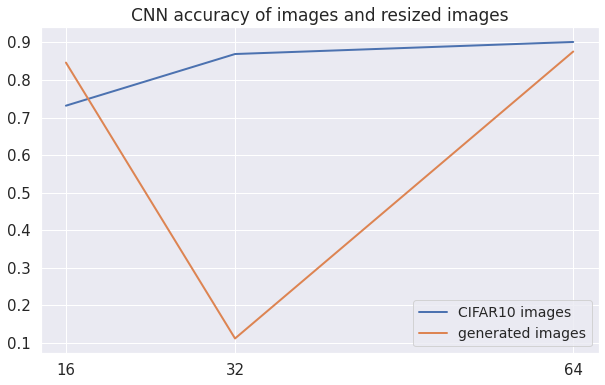

In [ ]:
acc_cifar = [0.73148, 0.86898, 0.90108]
acc_gen = [acc_16x16, acc_32x32, acc_64x64]
x_axis = [16, 32, 64]

fontsize = 17
linewidth = 2
plt.figure(figsize=(10, 6))
plt.xticks([16,32,64], fontsize=15)
plt.yticks(fontsize=15)
plt.plot(x_axis, acc_cifar, label='CIFAR10 images', linewidth=linewidth)
plt.plot(x_axis, acc_gen, label='generated images', linewidth=linewidth)
plt.title('CNN accuracy of images and resized images', fontsize=fontsize)
plt.legend(prop={'size':14})
plt.savefig('CNN_accuracy.png')
plt.show()